<a href="https://colab.research.google.com/github/saurabtharu/autoencoder/blob/main/Simple_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/saurabtharu/autoencoder/main/images/autoencoder.png" style="height: 100%; width:100%;">

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Data Preparation

## Defining data transformer

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
])

### Defining dataset from `MNIST`

In [ ]:
train_data = datasets.MNIST(root="./data",
                            train=True,
                            download=True,
                            transform=data_transform)

test_data = torchvision.datasets.MNIST(root="./data",
                                        train=False,
                                        download=True,
                                        transform=data_transform
                                      )

100%|██████████| 9912422/9912422 [00:00<00:00, 102167941.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24919912.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30800264.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4406784.36it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Defining DataLoader using `torch.utils.data.DataLoader`

In [ ]:
import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader
# define dataloader
import os

BATCH_SIZE = 64
NUM_WORKER = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKER
                            )

test_dataloader = DataLoader(dataset=test_data,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKER
                            )

In [ ]:
images, labes = list(train_dataloader)[0]
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# AutoEncoder Linear

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(in_features=28*28, out_features=128),       # N, 784 -> N,128
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=12),
        nn.ReLU(),
        nn.Linear(in_features=12, out_features=3)      # N, 3
    )
    self.decoder = nn.Sequential(
        nn.Linear(in_features=3, out_features=12),       # N, 3 ->
        nn.ReLU(),
        nn.Linear(in_features=12, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=28*28),      # N, 784
        nn.Sigmoid()
    )


  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# NOTE: [-1, 1 ]

# first model

In [ ]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

EPOCHS = 50
outputs_model = []

model_start_timer = timer()

for epoch in tqdm(range(EPOCHS)):
  for (img, _) in train_dataloader:
    img = img.reshape(-1, 28*28)
    img = img.to(device)
    reconstructed_image = model(img)
    loss = criterion(reconstructed_image, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch : {epoch:3} , Loss : {loss.item():.6f}")
  outputs_model.append((epoch, img, reconstructed_image))
model_stop_timer = timer()
model_total_time = model_stop_timer - model_start_timer
print(f"Total time to train model : {model_total_time}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch :   0 , Loss : 0.032756
Epoch :   1 , Loss : 0.033561
Epoch :   2 , Loss : 0.029673
Epoch :   3 , Loss : 0.024816
Epoch :   4 , Loss : 0.030884
Epoch :   5 , Loss : 0.026297
Epoch :   6 , Loss : 0.029599
Epoch :   7 , Loss : 0.036662
Epoch :   8 , Loss : 0.035244
Epoch :   9 , Loss : 0.030909
Epoch :  10 , Loss : 0.031796
Epoch :  11 , Loss : 0.027985
Epoch :  12 , Loss : 0.039137
Epoch :  13 , Loss : 0.028221
Epoch :  14 , Loss : 0.034549
Epoch :  15 , Loss : 0.035899
Epoch :  16 , Loss : 0.033835
Epoch :  17 , Loss : 0.030301
Epoch :  18 , Loss : 0.030488
Epoch :  19 , Loss : 0.029391
Epoch :  20 , Loss : 0.030671
Epoch :  21 , Loss : 0.027749
Epoch :  22 , Loss : 0.033229
Epoch :  23 , Loss : 0.039602
Epoch :  24 , Loss : 0.029358
Epoch :  25 , Loss : 0.032178
Epoch :  26 , Loss : 0.035701
Epoch :  27 , Loss : 0.028483
Epoch :  28 , Loss : 0.028755
Epoch :  29 , Loss : 0.027940
Epoch :  30 , Loss : 0.033304
Epoch :  31 , Loss : 0.036194
Epoch :  32 , Loss : 0.028032
Epoch :  3

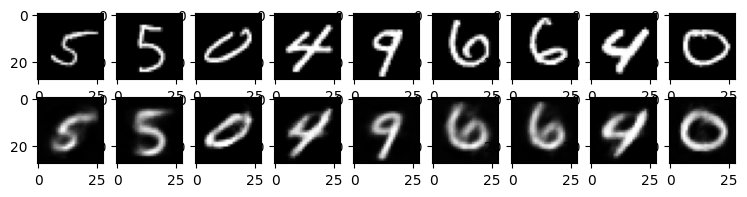

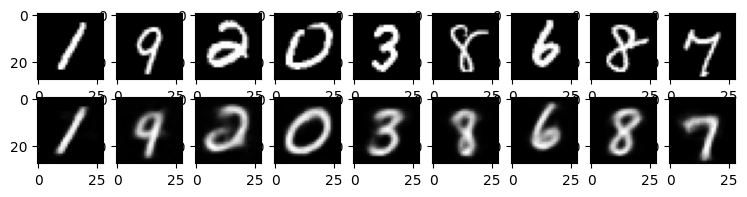

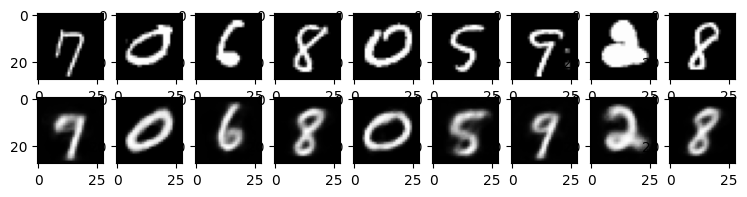

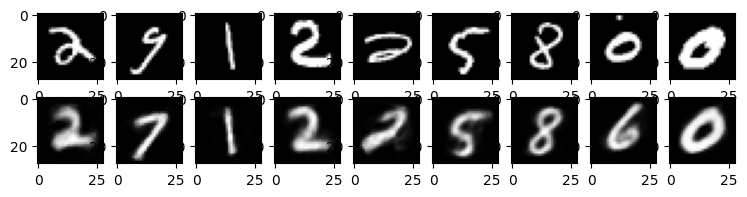

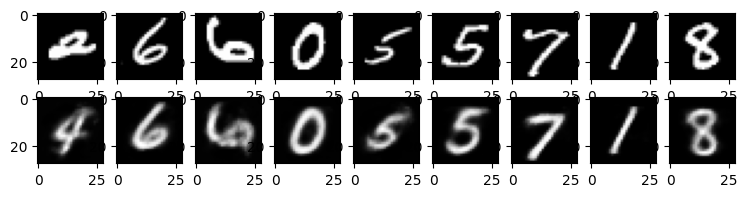

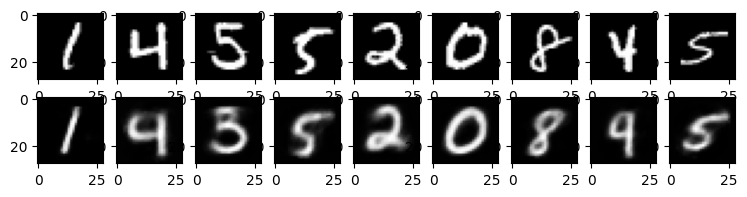

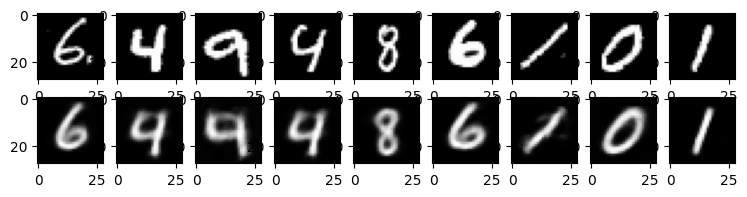

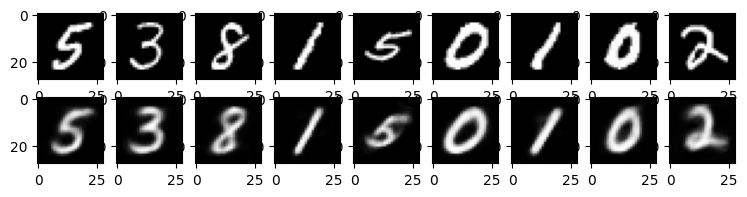

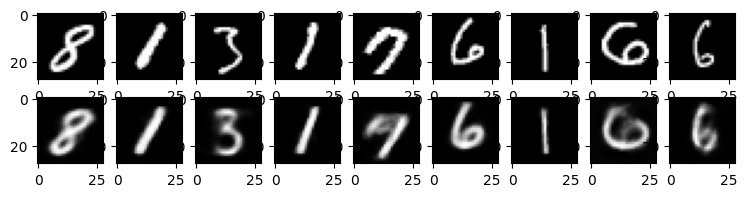

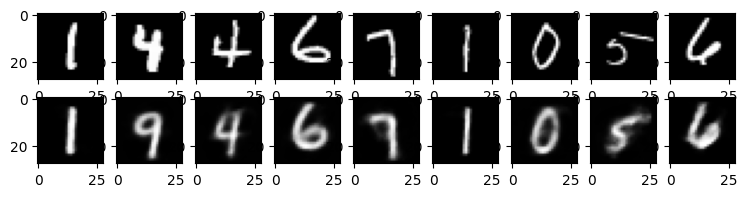

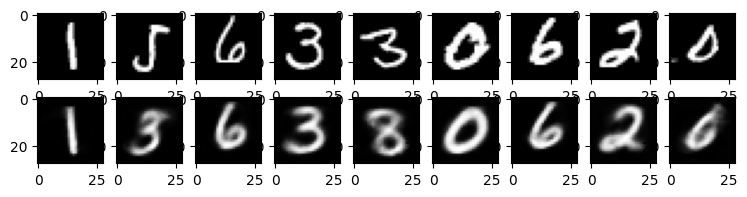

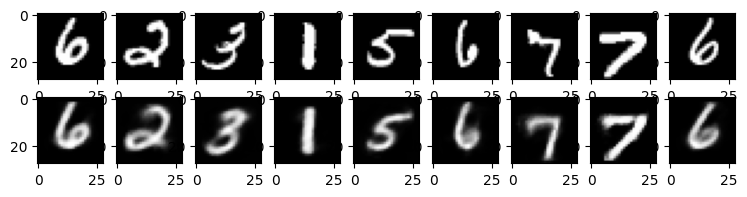

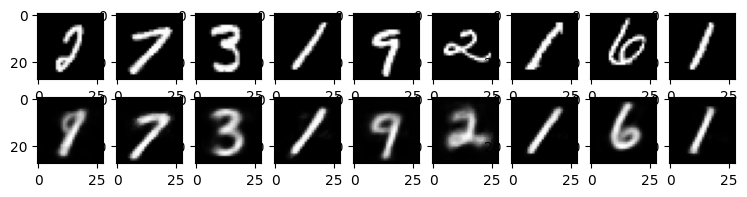

In [ ]:
import matplotlib.pyplot as plt

for k in range(0, EPOCHS, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs_model[k][1].cpu().detach().numpy()
  reconstructed_image = outputs_model[k][2].cpu().detach().numpy()

  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28)         # item.shape = [1, 28, 28]
    plt.imshow(item[0])

  for i, item in enumerate(reconstructed_image):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1)
    item = item.reshape(-1, 28, 28)         # item.shape = [1, 28, 28]
    plt.imshow(item[0])

# model 1

In [ ]:
from tqdm.auto import tqdm

model_1 = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3, weight_decay=1e-5)

EPOCHS = 150
outputs_model_1 = []



model_1_start_timer = timer()
for epoch in tqdm(range(EPOCHS)):
  for (img, _) in train_dataloader:
    img = img.reshape(-1, 28*28)
    img = img.to(device)
    reconstructed_image = model_1(img)
    loss = criterion(reconstructed_image, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch : {epoch:3} , Loss : {loss.item():.6f}")
  outputs_model_1.append((epoch, img, reconstructed_image))
model_1_stop_timer = timer()

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch :   0 , Loss : 0.044953
Epoch :   1 , Loss : 0.040467
Epoch :   2 , Loss : 0.037248
Epoch :   3 , Loss : 0.039684
Epoch :   4 , Loss : 0.037377
Epoch :   5 , Loss : 0.036446
Epoch :   6 , Loss : 0.036196
Epoch :   7 , Loss : 0.030712
Epoch :   8 , Loss : 0.035889
Epoch :   9 , Loss : 0.029501
Epoch :  10 , Loss : 0.035002
Epoch :  11 , Loss : 0.030325
Epoch :  12 , Loss : 0.033073
Epoch :  13 , Loss : 0.032069
Epoch :  14 , Loss : 0.030413
Epoch :  15 , Loss : 0.035551
Epoch :  16 , Loss : 0.036618
Epoch :  17 , Loss : 0.033559
Epoch :  18 , Loss : 0.034949
Epoch :  19 , Loss : 0.028460
Epoch :  20 , Loss : 0.038187
Epoch :  21 , Loss : 0.037007
Epoch :  22 , Loss : 0.030136
Epoch :  23 , Loss : 0.031188
Epoch :  24 , Loss : 0.032684
Epoch :  25 , Loss : 0.032835
Epoch :  26 , Loss : 0.027584
Epoch :  27 , Loss : 0.035097
Epoch :  28 , Loss : 0.034645
Epoch :  29 , Loss : 0.037458
Epoch :  30 , Loss : 0.033553
Epoch :  31 , Loss : 0.033755
Epoch :  32 , Loss : 0.029658
Epoch :  3

<ipython-input-51-c7204345a7f0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,2))


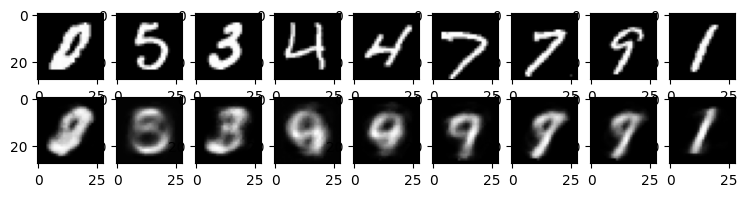

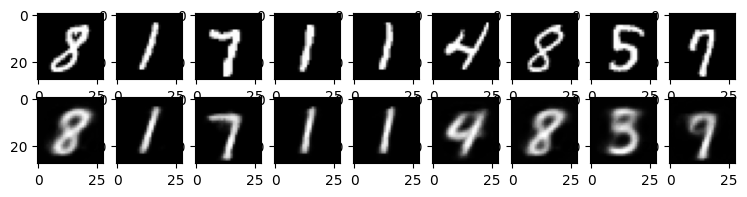

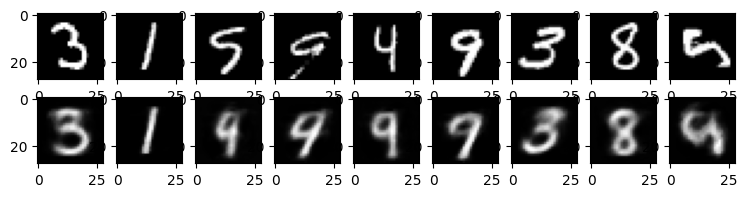

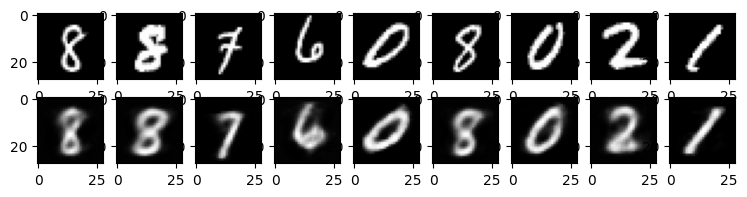

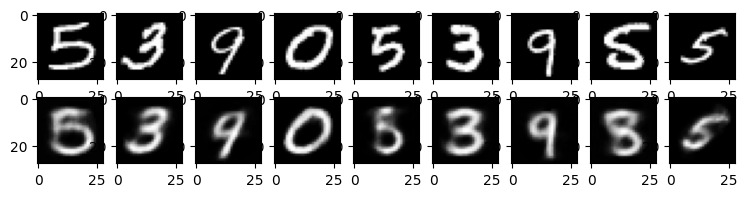

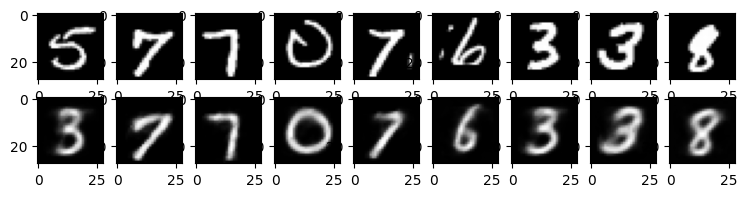

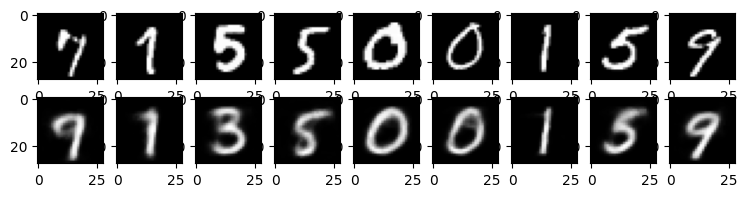

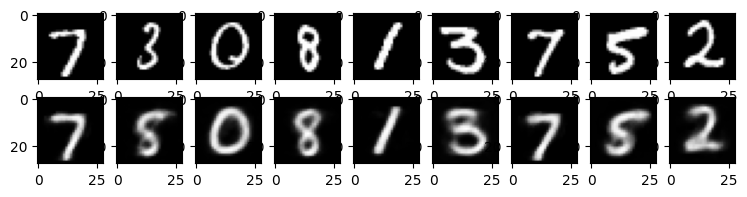

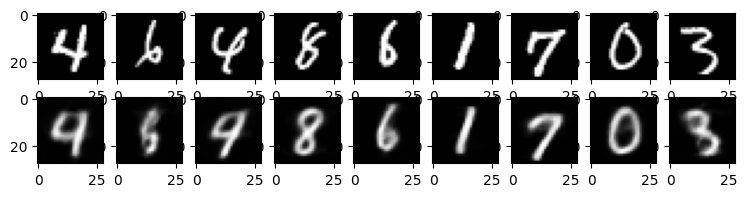

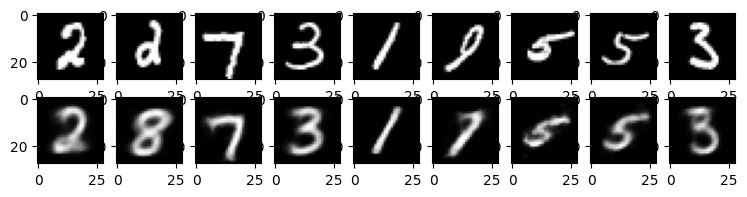

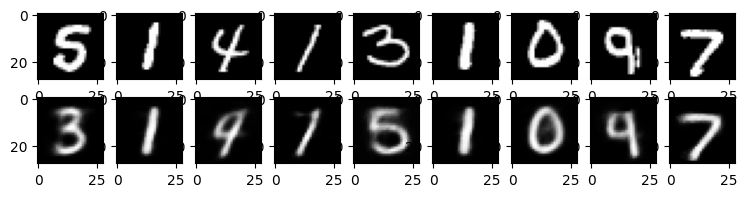

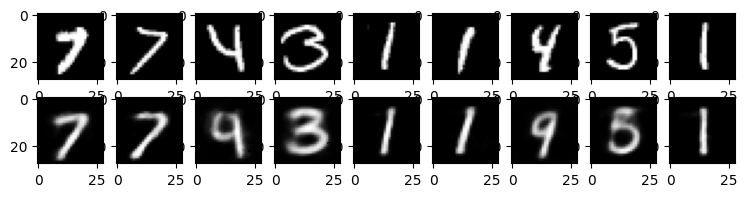

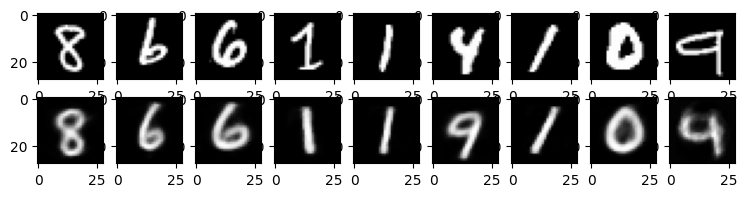

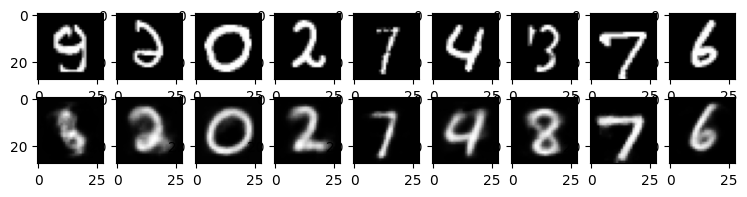

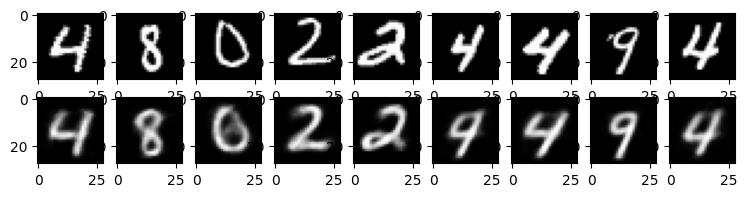

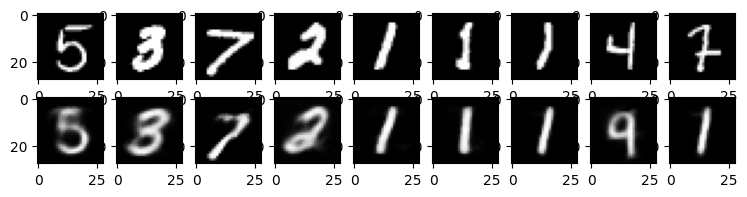

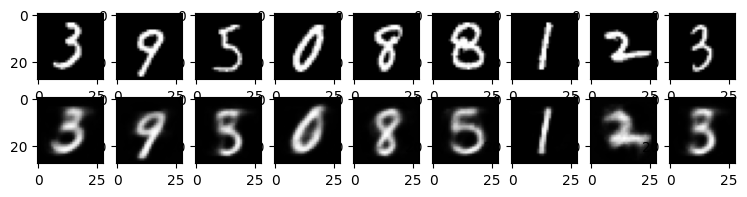

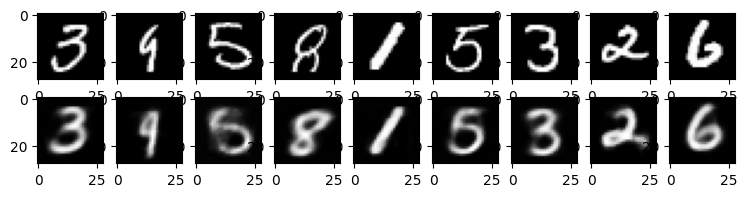

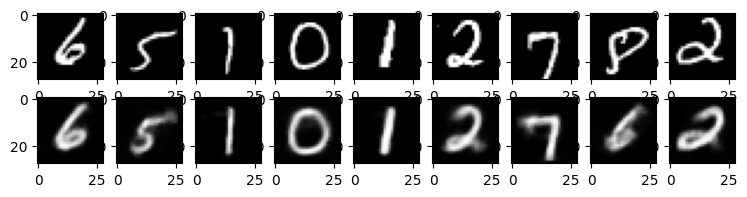

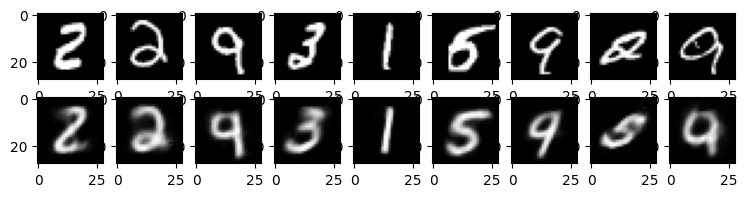

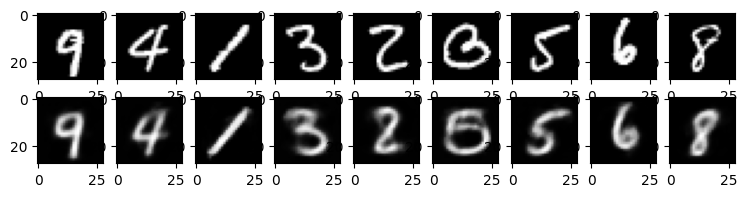

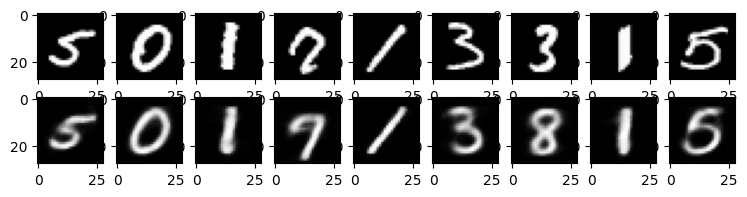

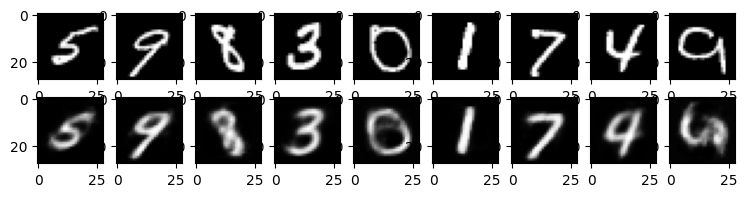

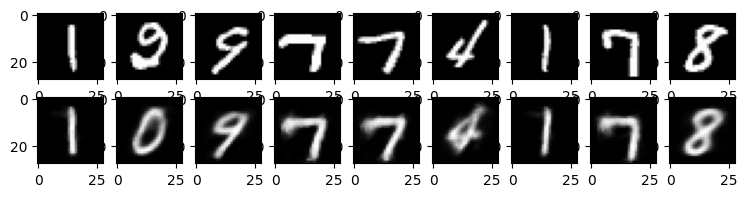

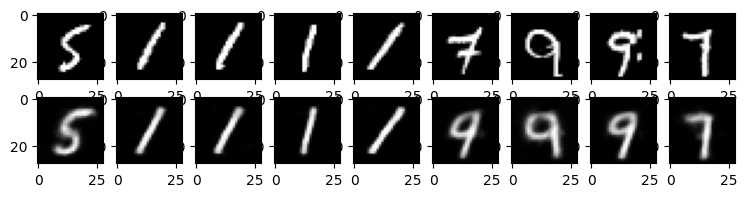

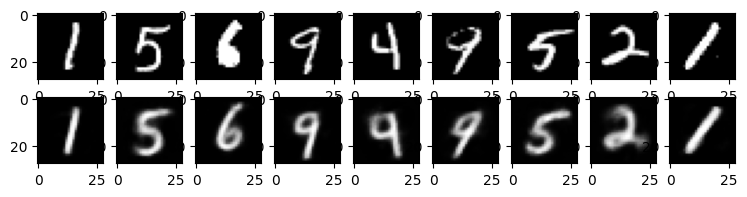

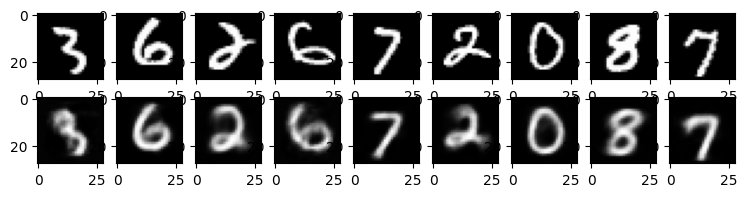

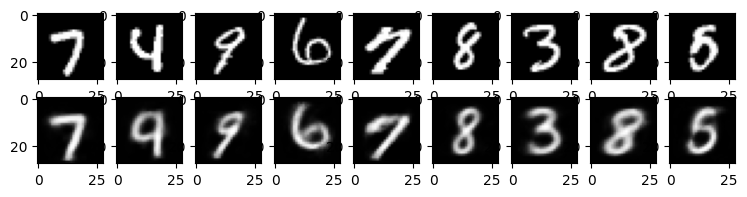

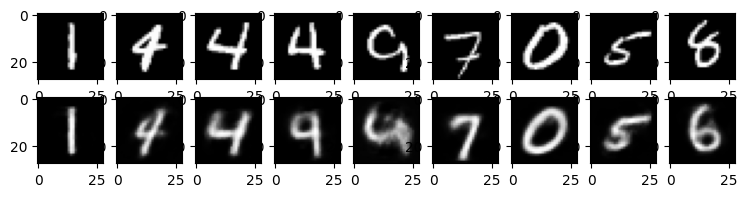

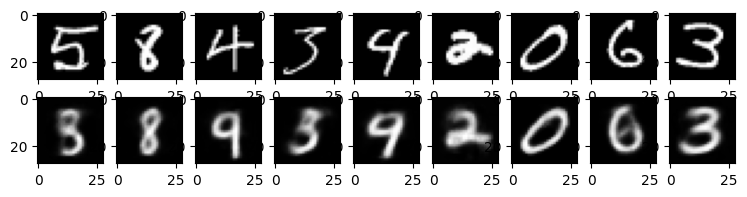

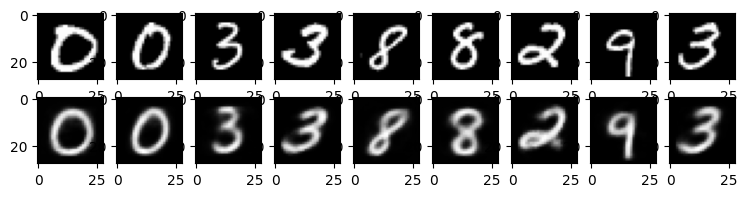

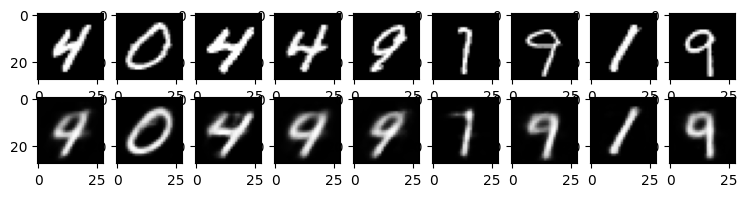

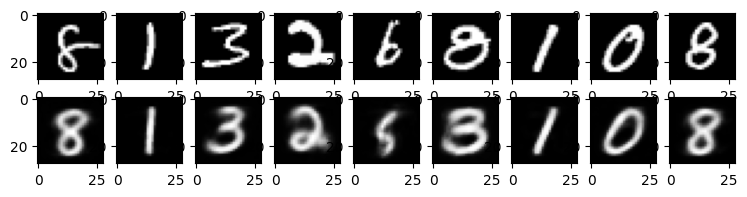

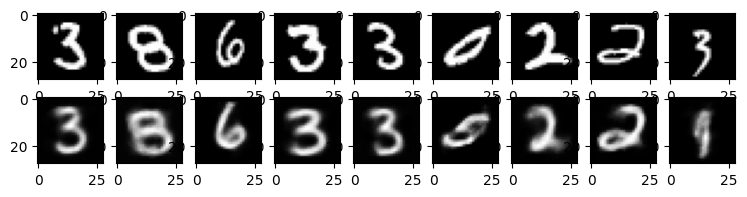

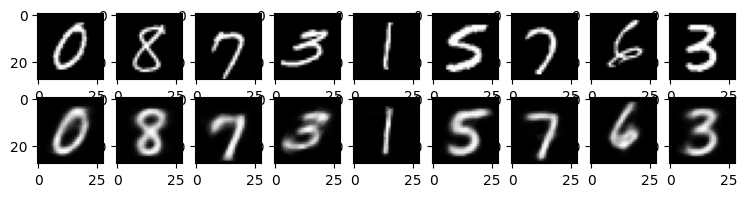

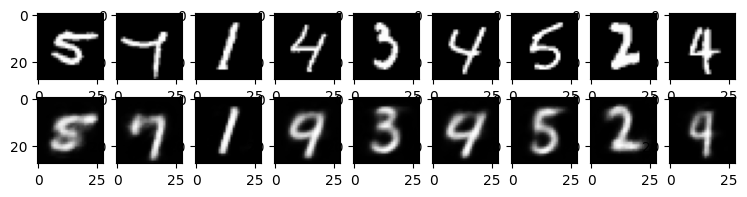

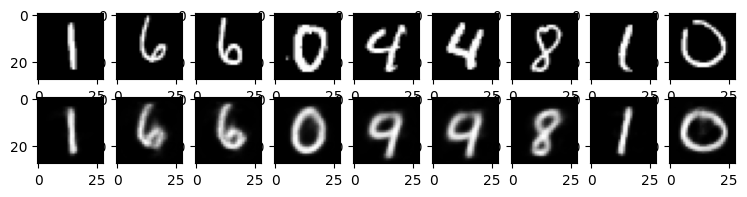

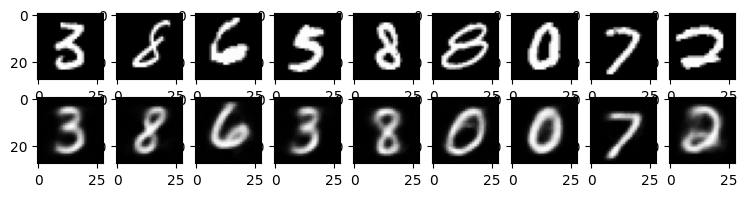

In [ ]:
for k in range(0, EPOCHS, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs_model_1[k][1].cpu().detach().numpy()
  reconstructed_image = outputs_model_1[k][2].cpu().detach().numpy()

  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28)         # item.shape = [1, 28, 28]
    plt.imshow(item[0])

  for i, item in enumerate(reconstructed_image):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1)
    item = item.reshape(-1, 28, 28)         # item.shape = [1, 28, 28]
    plt.imshow(item[0])

In [ ]:
for epoch in tqdm(range(10)):
  print(f"epoch : {epoch}")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
